# Image classification

Dalam project kali ini, saya mencoba mengklasifikasikan gambar member boygroup BTS. Pengklasifikasi gambar menggunakan model `keras.Sequential`, dan data dimuat menggunakan `preprocessing.image_dataset_from_directory`. 

Berikut alur kerja machine learning dasar yang digunakan:

1. Menelaah dan memahami data
2. Bangun input pipeline
3. Bangun modelnya
4. Latih modelnya (Training)
5. Uji modelnya
6. Tingkatkan model dan ulangi prosesnya

## Import TensorFlow dan libraries lainnya

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd
import seaborn as sns

## Memuat dataset yang sudah dibuat sebelumnya

Project ini menggunakan dataset sekitar 2.361 foto member BTS. Dataset berisi 7 sub-direktori, satu per kelas (setiap membernya):

```
cropped/
  jhope/
  jimin/
  jin/
  jungkook/
  rm/
  suga/
  v/
```

In [2]:
import pathlib

In [3]:
# !unzip -q cropped.zip
# !ls

In [4]:
!ls cropped

jhope  jimin  jin  jungkook  rm  suga  v


In [5]:
data_dir = pathlib.Path('/content/cropped')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2361


Berikut beberapa gambar dari salah satu member, J-Hope:

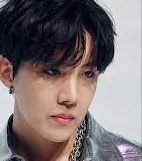

In [7]:
jhope = list(data_dir.glob('jhope/*'))
PIL.Image.open(str(jhope[0]))

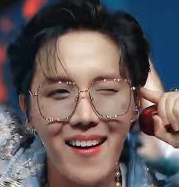

In [8]:
PIL.Image.open(str(jhope[1]))

Jin

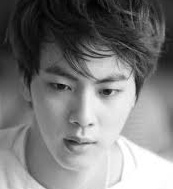

In [9]:
jin = list(data_dir.glob('jin/*'))
PIL.Image.open(str(jin[0]))

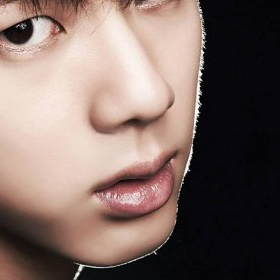

In [10]:
PIL.Image.open(str(jin[1]))

Jumlah gambar dalam dataset :  2361


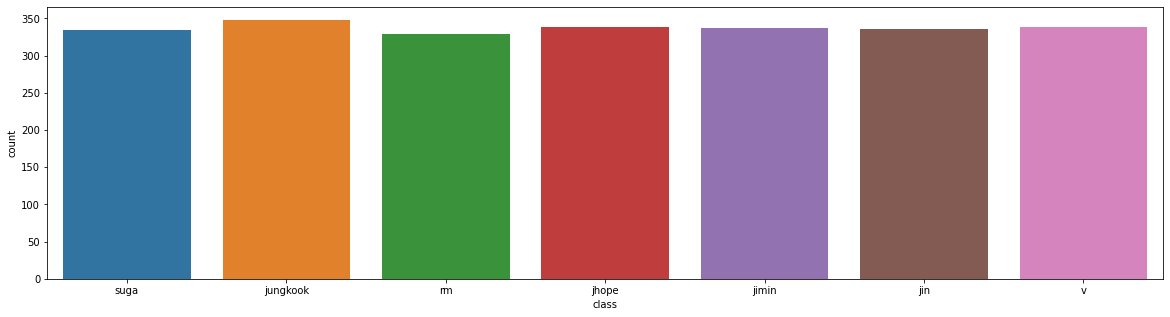

In [11]:
root_path = '/content/cropped'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/cropped' #one more seg_train folder within

quantity_tr = {} 

for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+'/'+folder))
 
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])

figure, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax)

print("Jumlah gambar dalam dataset : ", sum(quantity_tr.values()))

plt.show()

# Memuat data dengan keras.preprocessing

Memuat gambar-gambar ini dari disk menggunakan [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). Hal ini akan membawa kita dari direktori gambar pada disk ke `tf.data.Dataset` hanya dalam beberapa baris kode. Berikut adalah dokumentasi detail mengenai cara memuat data yang dimiliki oleh kita sendiri, seperti yang saya lakukan -> [memuat gambar](https://www.tensorflow.org/tutorials/load_data/images).

## Membuat dataset

Tentukan beberapa parameter untuk loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Ini adalah good practice untuk menggunakan validation split saat mengembangkan suatu model. Mari kita gunakan 80% dari gambar untuk training, dan 20% untuk validation.

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, smart_resize=True)

Found 2361 files belonging to 7 classes.
Using 1889 files for training.


In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size, smart_resize=True)

Found 2361 files belonging to 7 classes.
Using 472 files for validation.


Anda dapat menemukan nama kelas dalam atribut `class_names` pada kumpulan data ini. Ini sesuai dengan nama direktori dalam urutan abjad.

In [15]:
class_names = train_ds.class_names
print(class_names)

['jhope', 'jimin', 'jin', 'jungkook', 'rm', 'suga', 'v']


## Visualisasikan datanya

Berikut adalah 9 gambar pertama dari training dataset.

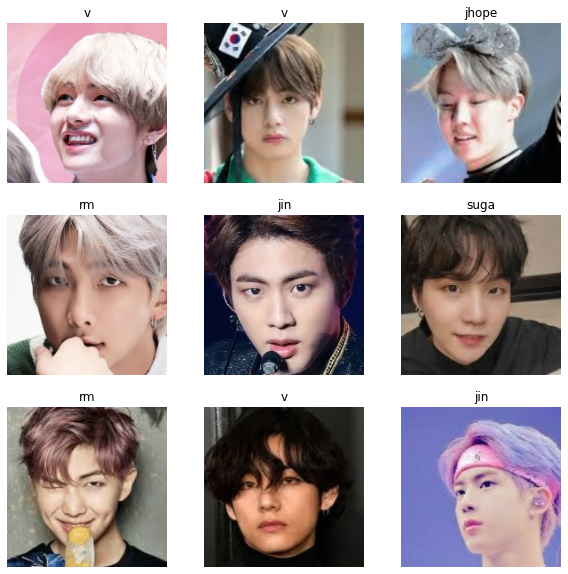

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Latih model menggunakan set data ini dengan menyimpannya pada function `model.fit` . Selain itu, kita juga dapat secara manual melakukan iterasi kumpulan data dan mengambil kumpulan gambar (batches):

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` adalah tensor dari shape `(32, 180, 180, 3)`. Ini adalah kumpulan 32 gambar berbentuk `180x180x3` (dimensi terakhir mengacu pada saluran warna RGB). `label_batch` adalah tensor dari shape `(32,)`, ini adalah label yang bersesuaian dengan 32 gambar.

Kita dapat memanggil `.numpy()` pada tensor `image_batch` dan `labels_batch` untuk mengonversinya menjadi `numpy.ndarray`.

## Konfigurasikan dataset untuk performance

Mari pastikan untuk menggunakan buffered prefetching sehingga kita dapat menghasilkan data dari disk tanpa I/O menjadi blocking. Ini adalah dua metode penting yang harus digunakan saat memuat data.

`Dataset.cache()` menyimpan gambar dalam memori setelah dimuat dari disk selama epoch pertama. Ini akan memastikan kumpulan data tidak menjadi hambatan saat melatih model kita. Jika kumpulan data yang dimiliki terlalu besar untuk dimasukkan ke dalam memori, kita juga dapat menggunakan metode ini untuk membuat cache di disk yang berkinerja baik.

`Dataset.prefetch()` overlaps dengan prapemrosesan data dan eksekusi model saat pelatihan/training.

Berikut informasi lebih lanjut tentang kedua metode tersebut, serta cara menyimpan data ke dalam cache di [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarisasi data

Nilai channel RGB berada dalam kisaran `[0, 255]`. Ini tidak ideal untuk neural network; secara umum kita harus berusaha membuat nilai input kita menjadi kecil. Di sini, kita akan menstandardisasi nilai agar berada dalam rentang `[0, 1]` dengan menggunakan layer Rescaling.

In [19]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Ada dua cara untuk menggunakan layer ini. Kita dapat menerapkannya ke dataset dengan memanggil map:

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


Atau, kita dapat menyertakan lapisan di dalam definisi model kita, yang dapat menyederhanakan penerapan. Mari kita gunakan pendekatan kedua di sini.

Catatan: kita sebelumnya mengubah ukuran gambar menggunakan argumen `image_size` dari `image_dataset_from_directory`. Jika kita juga ingin menyertakan resizing logic dalam model, kita pun dapat menggunakan layer [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing).

# Buat modelnya

Model ini terdiri dari tiga blok konvolusi dengan max pool layer di masing-masing blok. Ada layer yang sepenuhnya terhubung dengan 128 unit di atasnya yang diaktifkan oleh fungsi aktivasi `relu`. Model ini belum disetel untuk akurasi tinggi, sebagai pendekatan standar.

In [21]:
num_classes = 7

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Kompilasi modelnya

Untuk project ini, pilih fungsi pengoptimal `optimizers.Adam` dan `losses.SparseCategoricalCrossentropy`. Untuk melihat akurasi pelatihan dan validasi untuk setiap periode pelatihan, pass argumen `metrics`.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Ringkasan model

Lihat semua layer jaringan menggunakan metode `summary` model:

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Train model

In [24]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 [==============================] - 5s 32ms/step - loss: 1.9926 - accuracy: 0.1488 - val_loss: 1.9322 - val_accuracy: 0.1758
Epoch 2/10
60/60 [==============================] - 1s 20ms/step - loss: 1.8618 - accuracy: 0.2599 - val_loss: 1.8098 - val_accuracy: 0.3199
Epoch 3/10
60/60 [==============================] - 1s 20ms/step - loss: 1.5616 - accuracy: 0.4288 - val_loss: 1.6715 - val_accuracy: 0.4068
Epoch 4/10
60/60 [==============================] - 1s 20ms/step - loss: 1.1044 - accuracy: 0.6252 - val_loss: 1.6541 - val_accuracy: 0.4555
Epoch 5/10
60/60 [==============================] - 1s 20ms/step - loss: 0.6759 - accuracy: 0.7755 - val_loss: 1.6078 - val_accuracy: 0.5169
Epoch 6/10
60/60 [==============================] - 1s 20ms/step - loss: 0.3118 - accuracy: 0.9068 - val_loss: 1.8763 - val_accuracy: 0.5614
Epoch 7/10
60/60 [==============================] - 1s 21ms/step - loss: 0.1221 - accuracy: 0.9672 - val_loss: 2.2963 - val_accuracy: 0.5508
Epoch 8/10
60

## Visualisasikan hasil pelatihan

Buat plot loss dan akurasi pada set pelatihan dan validasi.

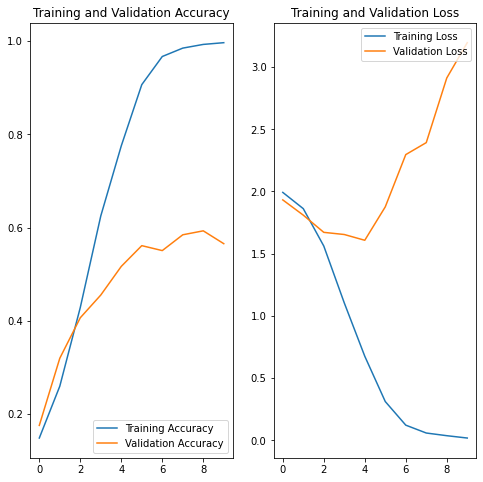

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Seperti yang dapat kita lihat dari plot, akurasi pelatihan dan akurasi validasi berbeda jauh dan model hanya mencapai akurasi sekitar 60% pada set validasi.

Mari kita lihat apa yang salah dan coba tingkatkan kinerja model secara keseluruhan.

## Overfitting

Dalam plot di atas, akurasi pelatihan meningkat secara linier dari waktu ke waktu, sedangkan akurasi validasi terhenti sekitar 60% dalam proses pelatihan. Juga, perbedaan akurasi antara akurasi pelatihan dan validasi terlihat — tanda dari [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Ketika hanya ada sejumlah kecil examples untuk training, model terkadang "belajar" dari noises atau detail yang tidak diinginkan dari examples pelatihan — hal itu berdampak negatif pada kinerja model pada examples baru. Fenomena ini dikenal sebagai overfitting. Ini berarti bahwa model akan mengalami kesulitan untuk melakukan generalisasi pada dataset baru.

Ada beberapa cara untuk mengatasi overfitting dalam proses pelatihan. Dalam project ini, kita akan menggunakan *data augmentation* dan menambahkan *Dropout* ke model kita.

## Data augmentation

Overfitting umumnya terjadi ketika hanya ada sejumlah kecil examples untuk pelatihan. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) mengambil pendekatan untuk menghasilkan data pelatihan tambahan dari contoh yang ada dengan menambahkannya menggunakan transformasi acak yang menghasilkan gambar lainnya. Ini membantu mengekspos model ke lebih banyak aspek data dan menggeneralisasi lebih baik.

Kita akan menerapkan augmentasi data menggunakan layers dari `tf.keras.layers.experimental.preprocessing`. Ini dapat dimasukkan ke dalam model kita seperti layers lain, dan berjalan di GPU.

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(factor=0.15),
    layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.experimental.preprocessing.RandomZoom(0.05)
  ]
)

Mari kita visualisasikan seperti apa beberapa contoh augmented dengan menerapkan augmentasi data ke gambar yang sama beberapa kali:

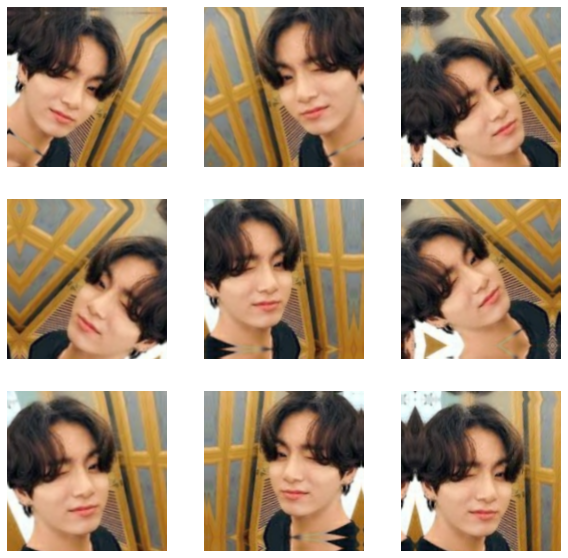

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Teknik lain untuk mengurangi overfitting adalah dengan memperkenalkan [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) pada network, salah satu bentuk *regularization*.

Saat kita menerapkan Dropout ke suatu layer, itu secara acak menjatuhkan (drops out) (dengan mengatur aktivasi ke nol) sejumlah unit keluaran dari layer selama proses pelatihan. Dropout mengambil angka pecahan sebagai nilai inputnya, dalam bentuk seperti 0.1, 0.2, 0.4, dll. Ini berarti drop out 10%, 20% atau 40% dari unit output secara acak dari layer yang diterapkan.

Mari buat neural network baru menggunakan `layers.Dropout`, lalu latih menggunakan gambar yang diperbesar.

In [28]:
# model = Sequential([
#   data_augmentation,
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.4),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

## Compile dan train model

In [29]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

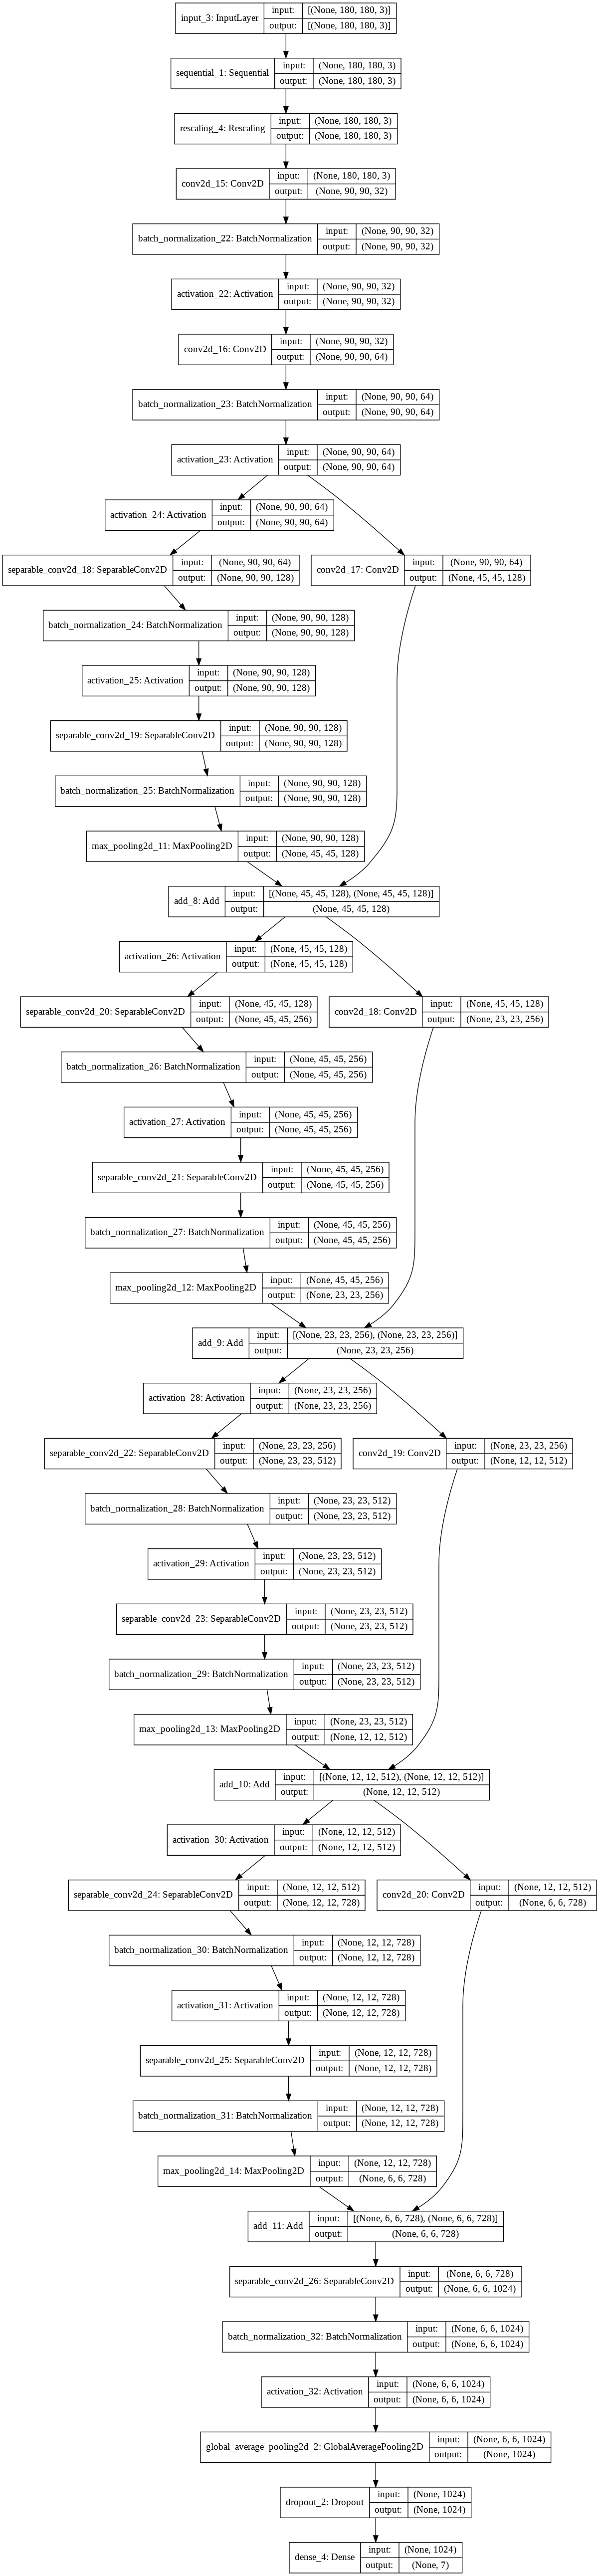

In [55]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(img_width, img_height) + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 180, 180, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 180, 180, 3)  0           sequential_1[2][0]               
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 90, 90, 32)   896         rescaling_4[0][0]                
____________________________________________________________________________________________

In [57]:
epochs = 75

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/75
60/60 [==============================] - 18s 263ms/step - loss: 2.1258 - accuracy: 0.1800 - val_loss: 1.9481 - val_accuracy: 0.1314


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/75
60/60 [==============================] - 16s 264ms/step - loss: 1.9963 - accuracy: 0.1837 - val_loss: 1.9604 - val_accuracy: 0.1314
Epoch 3/75
60/60 [==============================] - 15s 252ms/step - loss: 1.9629 - accuracy: 0.1985 - val_loss: 1.9727 - val_accuracy: 0.1314
Epoch 4/75
60/60 [==============================] - 15s 249ms/step - loss: 1.9306 - accuracy: 0.2028 - val_loss: 2.0106 - val_accuracy: 0.1314
Epoch 5/75
60/60 [==============================] - 15s 253ms/step - loss: 1.9043 - accuracy: 0.2313 - val_loss: 2.0666 - val_accuracy: 0.1314
Epoch 6/75
60/60 [==============================] - 15s 253ms/step - loss: 1.8769 - accuracy: 0.2446 - val_loss: 2.0564 - val_accuracy: 0.1314
Epoch 7/75
60/60 [==============================] - 15s 252ms/step - loss: 1.8571 - accuracy: 0.2488 - val_loss: 2.1823 - val_accuracy: 0.1314
Epoch 8/75
60/60 [==============================] - 15s 251ms/step - loss: 1.8471 - accuracy: 0.2525 - val_loss: 2.2247 - val_accuracy: 0.1314

## Visualisasikan hasil training

Setelah menerapkan augmentasi data dan Dropout, overfitting lebih sedikit daripada sebelumnya, dan akurasi pelatihan dan validasi lebih selaras.

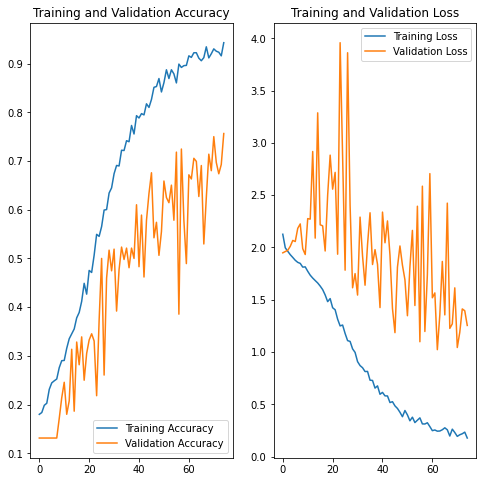

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Memprediksi data baru

Terakhir, mari gunakan model kita untuk mengklasifikasikan gambar yang tidak disertakan dalam set pelatihan atau validasi.

Catatan: Layer augmentasi data dan Dropout tidak aktif pada waktu inference.

In [52]:
# model = tf.keras.models.load_model('save_at_57.h5')

In [61]:
img = keras.preprocessing.image.load_img(
    '/content/jin.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Gambar ini kemungkinan besar adalah {} dengan {:.2f} % confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Gambar ini kemungkinan besar adalah jin dengan 31.01 % confidence.


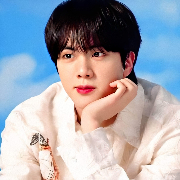

In [62]:
img

In [63]:
model = tf.keras.models.load_model('save_at_75.h5')

In [92]:
results = model.predict(val_ds)
results.shape

(472, 7)

In [106]:
from sklearn.metrics import confusion_matrix
true_categories = tf.concat([y for x, y in val_ds], axis=0)
predicted_categories = tf.argmax(results, axis=1)

array([[58,  9,  8,  6,  2,  4, 10],
       [ 1, 44,  0,  2,  0,  0,  6],
       [ 0,  5, 49,  3,  0,  1,  4],
       [ 6,  6,  1, 54,  2,  6,  7],
       [ 0,  0,  1,  0, 61,  0,  0],
       [ 3,  3,  2,  3,  1, 63,  5],
       [ 0,  1,  1,  0,  4,  2, 28]])

In [1]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = class_names
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(model_pred, true_value)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

NameError: ignored

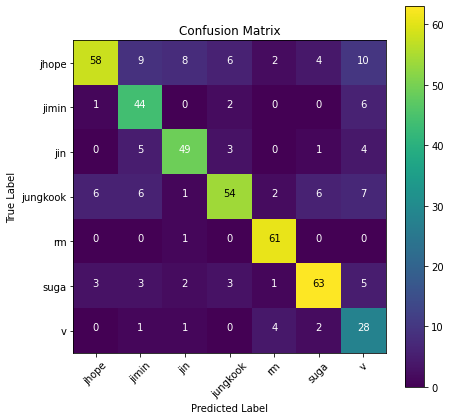

In [110]:
clf_report(true_categories, predicted_categories)